In [9]:
import os, re,json
import cv2
import numpy as np
import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import PILToTensor,ToPILImage
from sklearn.model_selection import train_test_split
from DatasetUtils.DataParsing import leafDataset
from modelTraining.modelDefinition import get_instance_segmentation_model
from modelTraining.engine import train_one_epoch, evaluate
from modelTraining.utils import collate_fn

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [10]:
images = os.listdir(os.path.join(os.getcwd(),"Datasets/Mask_rcnn_training_dataset/images"))
train,test = train_test_split(images,test_size=0.2,train_size=0.8)
train_images = [os.path.join(os.getcwd(),"Datasets/Mask_rcnn_training_dataset/images",e) for e in train]
train_json = [os.path.join(os.getcwd(),"Datasets/Mask_rcnn_training_dataset/","Annotations",re.sub("\.png|\.jpg",".json",e)) for e in train]
test_images = [os.path.join(os.getcwd(),"Datasets/Mask_rcnn_training_dataset/images",e) for e in test]
test_json = [os.path.join(os.getcwd(),"Datasets/Mask_rcnn_training_dataset/","Annotations",re.sub("\.png|\.jpg",".json",e)) for e in test]

In [11]:
train_dataset = leafDataset(train_images,train_json)
data_loader = DataLoader(train_dataset,collate_fn=collate_fn,batch_size=4)
test_dataset = leafDataset(test_images,test_json)
data_loader_test = DataLoader(test_dataset,collate_fn=collate_fn,batch_size=2)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

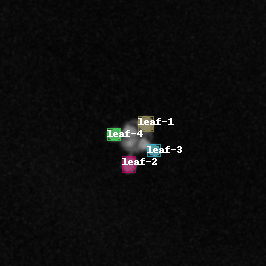

In [12]:
train_dataset.plotExampleWithMasks(np.random.randint(0,len(train_dataset)))

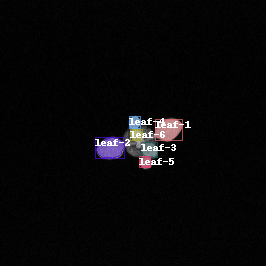

In [13]:
test_dataset.plotExampleWithMasks(np.random.randint(0,len(test_dataset)))

In [14]:
model = get_instance_segmentation_model(2)
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [15]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)



In [16]:
num_epochs = 10


import time
hora= time.gmtime()
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

torch.save(model.state_dict(), "Models/Leaf_Segmentation_MaskedRCNN_{}_{}_{}_{}h.h5".format(
    hora.tm_mday,hora.tm_mon,hora.tm_year,hora.tm_hour))
with open("Models/last.txt","w") as o:
    o.write("Models/Leaf_Segmentation_MaskedRCNN_{}_{}_{}_{}h.h5".format(
    hora.tm_mday,hora.tm_mon,hora.tm_year,hora.tm_hour))

Epoch: [0]  [ 0/33]  eta: 0:00:37  lr: 0.000161  loss: 7.0734 (7.0734)  loss_classifier: 0.5746 (0.5746)  loss_box_reg: 0.6114 (0.6114)  loss_mask: 4.5819 (4.5819)  loss_objectness: 1.1617 (1.1617)  loss_rpn_box_reg: 0.1438 (0.1438)  time: 1.1490  data: 0.0000  max mem: 4107
Epoch: [0]  [10/33]  eta: 0:00:22  lr: 0.001722  loss: 2.9649 (3.6483)  loss_classifier: 0.5210 (0.5130)  loss_box_reg: 0.7873 (0.7470)  loss_mask: 1.3245 (1.9179)  loss_objectness: 0.1263 (0.4239)  loss_rpn_box_reg: 0.0402 (0.0464)  time: 0.9844  data: 0.0002  max mem: 4621
Epoch: [0]  [20/33]  eta: 0:00:12  lr: 0.003283  loss: 1.9225 (2.7072)  loss_classifier: 0.4210 (0.4514)  loss_box_reg: 0.7778 (0.7559)  loss_mask: 0.5282 (1.1970)  loss_objectness: 0.0744 (0.2583)  loss_rpn_box_reg: 0.0369 (0.0447)  time: 0.9706  data: 0.0001  max mem: 4621
Epoch: [0]  [30/33]  eta: 0:00:02  lr: 0.004844  loss: 1.4360 (2.2187)  loss_classifier: 0.3021 (0.3848)  loss_box_reg: 0.7330 (0.7074)  loss_mask: 0.3217 (0.8950)  loss_ob